<a href="https://colab.research.google.com/github/yara-esmaiel/Bitcoin-price-prediction/blob/main/Bitcoin_Price_Prediction_(LSTM%2C_Layers%3D1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LAYERS =1, LSTM
PENALITY =9
WINDOW SIZE = 15, 30 , 60
TIME= 1-1-2015 TO 24-6-2022   


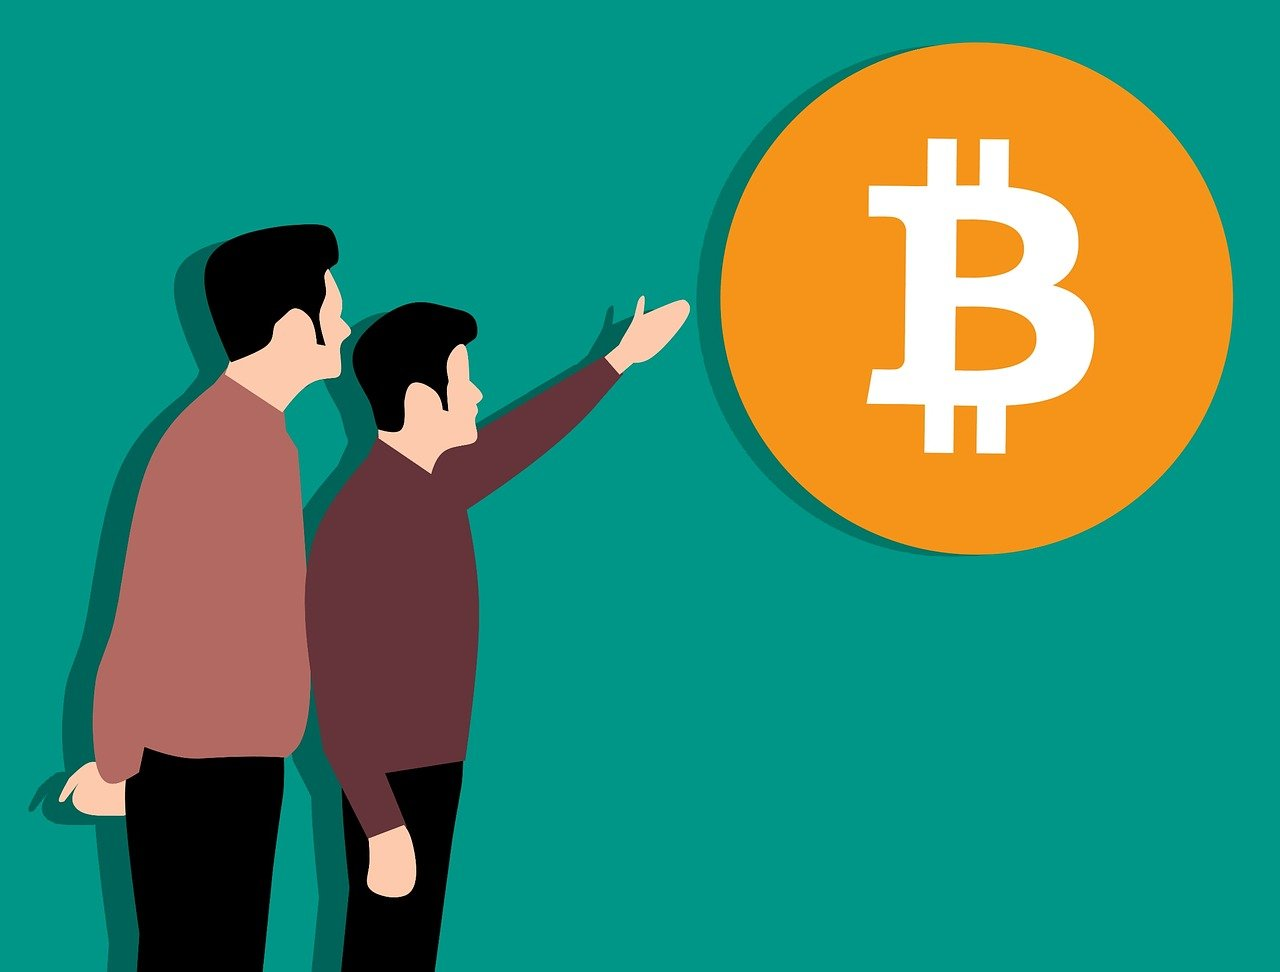

# Pre-Processing

In [1]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:

from numpy.random import seed
seed(1)
from tensorflow import keras
SEED = 1
keras.utils.set_random_seed(SEED)

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [4]:
# Load our dataset 
# Note it should be in same dir


maindf=pd.read_csv('/content/drive/MyDrive/BTC/BTC-USD from2014 to 24-6-2022.csv')

In [5]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2022-06-24


In [6]:
maindf.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
maindf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2838 non-null   object 
 1   Open       2838 non-null   float64
 2   High       2838 non-null   float64
 3   Low        2838 non-null   float64
 4   Close      2838 non-null   float64
 5   Adj Close  2838 non-null   float64
 6   Volume     2838 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.3+ KB


In [8]:
maindf.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2.838000e+03
mean,12399.341018,12722.525499,12036.373224,12405.003057,12405.003057,1.539525e+10
std,16612.757792,17042.075739,16114.435061,16608.324661,16608.324661,1.995297e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,629.677506,639.339523,620.328247,630.604264,630.604264,8.595492e+07
50%,6532.800049,6635.975098,6447.389892,6532.510010,6532.510010,5.680985e+09
75%,11430.774658,11763.756836,11184.256103,11468.886963,11468.886963,2.628780e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [9]:
#Checking for Null Values
print('Null Values:',maindf.isnull().values.sum())


Null Values: 0


In [10]:
print('NA values:',maindf.isnull().values.any())


NA values: False


In [11]:
maindf.shape


(2838, 7)

In [12]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2838, 2)


In [13]:
#Now we will Take data of just 1 Year

closedf = closedf[(closedf['Date'] > '2015-01-1') & (closedf['Date'] < '2022-06-15')]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2713


In [14]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
realdf=closedf
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
print(closedf)

(2713, 1)
[[0.00143485]
 [0.00129928]
 [0.00133098]
 ...
 [0.39449545]
 [0.33105368]
 [0.32688985]]


In [15]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
#print("train_data: ", train_data)
#print("test_data: ", test_data)


train_data:  (1627, 1)
test_data:  (1086, 1)


In [16]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# **window=15**

In [17]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1611, 15)
y_train:  (1611,)
X_test:  (1070, 15)
y_test (1070,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1611, 15, 1)
X_test:  (1070, 15, 1)


In [19]:
y_test 

array([0.17775095, 0.16591142, 0.17269778, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [20]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [21]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout
# Actuall Model Building
modelLSTM=Sequential()
modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path15 = 'my_best_model15.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint15 = ModelCheckpoint(filepath=checkpoint_path15, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint15, earlystopping]


In [22]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
48/51 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0018
Epoch 1: val_mean_squared_error improved from inf to 0.09657, saving model to my_best_model15.hdf5
51/51 [==============================] - 3s 26ms/step - loss: 0.0030 - mean_squared_error: 0.0017 - val_loss: 0.1931 - val_mean_squared_error: 0.0966
Epoch 2/300
51/51 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0024
Epoch 2: val_mean_squared_error improved from 0.09657 to 0.09575, saving model to my_best_model15.hdf5
51/51 [==============================] - 1s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0024 - val_loss: 0.1915 - val_mean_squared_error: 0.0957
Epoch 3/300
48/51 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0034
Epoch 3: val_mean_squared_error improved from 0.09575 to 0.08275, saving model to my_best_model15.hdf5
51/51 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squa

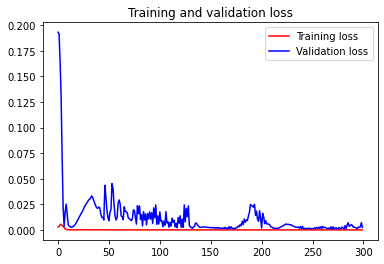

<Figure size 432x288 with 0 Axes>

In [23]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
from keras.models import load_model
model_from_saved_checkpoint15 = load_model('/content/my_best_model15.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint15.predict(X_train)
test_predict=model_from_saved_checkpoint15.predict(X_test)
train_predict.shape, test_predict.shape

((1611, 1), (1070, 1))

In [26]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [27]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[30027.365]
 [30635.414]
 [30531.543]
 [32435.752]
 [31528.076]
 [30607.39 ]
 [30800.277]
 [29401.17 ]
 [28883.479]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=15`

In [28]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  426.0833014058476
Train data MSE:  181546.97973690633
Train data MAE:  344.13688446661166
-------------------------------------------------------------------------------------
Test data RMSE:  1638.5590990514759
Test data MSE:  2684875.9210843844
Test data MAE:  1077.0148478553444


In [29]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9869240657164523
Test data explained variance regression score: 0.9922317082570812


In [30]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9868437042338162
Test data R2 score: 0.9922272374077102


In [31]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
#print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
#print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Test data MGD:  0.0028186918726844402
----------------------------------------------------------------------
Test data MPD:  70.22280173820059


## Custom Score 

In [32]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [33]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-0.0577458]
Y error positive : [0.66977064]
Y total_error : [0.61202483]


In [34]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.04557833]
Y error positive : [0.03683659]
Y total_error : [-0.00874174]


In [35]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 5 days
DEPENDING ON BEST WINDOW (W=)



In [36]:
time_step=15
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.4395539  0.4494726  0.43814878 0.44005597 0.44115034 0.46287519
 0.45968187 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545
 0.33105368 0.32688985 0.33832145]
1 day output [[0.34825176]]
2 day input [0.4494726  0.43814878 0.44005597 0.44115034 0.46287519 0.45968187
 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368
 0.32688985 0.33832145 0.34825176]
2 day output [[0.35652325]]
3 day input [0.43814878 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629
 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985
 0.33832145 0.34825176 0.35652325]
3 day output [[0.36427435]]
4 day input [0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.33832145
 0.34825176 0.35652325 0.36427435]
4 day output [[0.37224138]]
Output of predicted next days:  5


## Plotting last 15 days of dataset and next predicted 7 days

In [37]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20]


In [38]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[22977.154018888246, 23646.345127383254, 24203.749994664297, 24726.087228272983, 25262.974888887922]


In [39]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=30**

In [40]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1596, 30)
y_train:  (1596,)
X_test:  (1055, 30)
y_test (1055,)


In [41]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1596, 30, 1)
X_test:  (1055, 30, 1)


In [42]:
y_test 

array([0.14444165, 0.14382526, 0.13799897, ..., 0.41821102, 0.39449545,
       0.33105368])

## LOSS FUN

In [43]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [44]:
import keras.backend as K

from keras.layers import Dense, LSTM, Dropout
# Actuall Model Building
modelLSTM=Sequential()
modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path30 = 'my_best_model30.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint30 = ModelCheckpoint(filepath=checkpoint_path30, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint30, earlystopping]


In [45]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/50 [============================>.] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 1: val_mean_squared_error improved from inf to 0.08383, saving model to my_best_model30.hdf5
50/50 [==============================] - 4s 40ms/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.1677 - val_mean_squared_error: 0.0838
Epoch 2/300
49/50 [============================>.] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 2: val_mean_squared_error improved from 0.08383 to 0.06077, saving model to my_best_model30.hdf5
50/50 [==============================] - 2s 35ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.1215 - val_mean_squared_error: 0.0608
Epoch 3/300
49/50 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0023
Epoch 3: val_mean_squared_error improved from 0.06077 to 0.05405, saving model to my_best_model30.hdf5
50/50 [==============================] - 2s 36ms/step - loss: 0.0033 - mean_squa

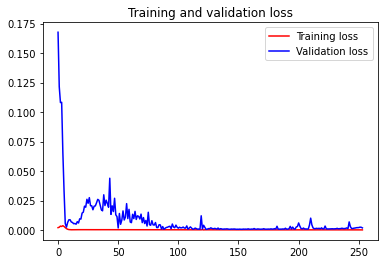

<Figure size 432x288 with 0 Axes>

In [46]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [47]:
from keras.models import load_model
model_from_saved_checkpoint30 = load_model('/content/my_best_model30.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [48]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint30.predict(X_train)
test_predict=model_from_saved_checkpoint30.predict(X_test)
train_predict.shape, test_predict.shape

((1596, 1), (1055, 1))

In [49]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [50]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[30414.1  ]
 [30521.79 ]
 [30688.55 ]
 [32296.074]
 [32181.736]
 [30998.672]
 [30743.963]
 [29732.834]
 [28942.674]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=30`

In [51]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  988.2061432303667
Train data MSE:  976551.3815182361
Train data MAE:  853.7671450715314
-------------------------------------------------------------------------------------
Test data RMSE:  1376.6202998366184
Test data MSE:  1895083.449922261
Test data MAE:  861.5748926006515


In [52]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9717812807043625
Test data explained variance regression score: 0.9945614009868705


In [53]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9294134366194268
Test data R2 score: 0.9945274043916261


In [54]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.6567996781698634
Test data MGD:  0.0017275428660839844
----------------------------------------------------------------------
Train data MPD:  703.021478360488
Test data MPD:  48.163158112842936


## Custom Score 

In [55]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [56]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-2.0007671]
Y error positive : [0.03091653]
Y total_error : [-1.96985057]


In [57]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.03112292]
Y error positive : [0.02764682]
Y total_error : [-0.0034761]


In [58]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [59]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [60]:
time_step=30
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.33116627]
1 day output [[0.3393867]]
2 day input [0.42354516 0.4471999  0.43067497 0.43411006 0.44733922 0.42916389
 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381
 0.4681538  0.469132   0.4395539  0.4494726  0.43814878 0.44005597
 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738 0.42893973
 0.41821102 0.39449545 0.33105368 0.32688985 0.33116627 0.3393867 ]
2 day output [[0.3515416]]
3 day input [0.4471999  0.43067497 0.43411006 0.44733922 0.42916389 0.43742455
 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381 0.4681538
 0.469132   0.4395539  0.4494726  0.43814878 0.44005597 0.44115034
 0.46287519 0.45968187 0.44571629 0.44

## Plotting last 30 days of dataset and next predicted 15 days

In [61]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[31 32 33 34 35]


In [62]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[22494.975562148724, 23048.940142133462, 23868.0438281139, 24846.832676509017, 25927.657272934477]


In [63]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=60**

In [64]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1566, 60)
y_train:  (1566,)
X_test:  (1025, 60)
y_test (1025,)


In [65]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1566, 60, 1)
X_test:  (1025, 60, 1)


In [66]:
y_test 

array([0.14812356, 0.14780536, 0.15125256, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [67]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [68]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout
# Actuall Model Building
modelLSTM=Sequential()
modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path60 = 'my_best_model60.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint60 = ModelCheckpoint(filepath=checkpoint_path60, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint60, earlystopping]


In [69]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/49 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 1: val_mean_squared_error improved from inf to 0.09582, saving model to my_best_model60.hdf5
49/49 [==============================] - 5s 71ms/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.1916 - val_mean_squared_error: 0.0958
Epoch 2/300
49/49 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0025
Epoch 2: val_mean_squared_error improved from 0.09582 to 0.06830, saving model to my_best_model60.hdf5
49/49 [==============================] - 3s 65ms/step - loss: 0.0040 - mean_squared_error: 0.0025 - val_loss: 0.1365 - val_mean_squared_error: 0.0683
Epoch 3/300
49/49 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0030
Epoch 3: val_mean_squared_error improved from 0.06830 to 0.05767, saving model to my_best_model60.hdf5
49/49 [==============================] - 3s 66ms/step - loss: 0.0047 - mean_squa

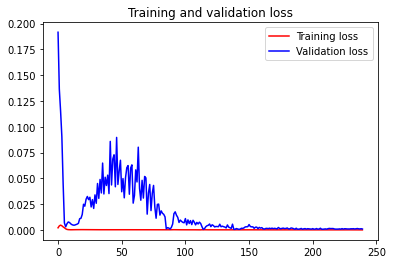

<Figure size 432x288 with 0 Axes>

In [70]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [71]:
from keras.models import load_model
model_from_saved_checkpoint60 = load_model('/content/my_best_model60.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [72]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint60.predict(X_train)
test_predict=model_from_saved_checkpoint60.predict(X_test)
train_predict.shape, test_predict.shape

((1566, 1), (1025, 1))

In [73]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [74]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[29524.205]
 [29462.43 ]
 [29563.838]
 [30982.135]
 [31182.533]
 [30261.334]
 [29852.166]
 [28836.576]
 [27936.42 ]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=60

In [75]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  955.7715739033861
Train data MSE:  913499.3014817558
Train data MAE:  806.2772558097113
-------------------------------------------------------------------------------------
Test data RMSE:  1363.4635601187601
Test data MSE:  1859032.8797717236
Test data MAE:  859.3010880341462


In [76]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9688022289043098
Test data explained variance regression score: 0.99468733951583


In [77]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9343018417037049
Test data R2 score: 0.9946533877888905


In [78]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.6267579869430377
Test data MGD:  0.001725322653953098
----------------------------------------------------------------------
Train data MPD:  670.322502340653
Test data MPD:  47.38199828962094


## Custom Score 

In [79]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [80]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-1.90877094]
Y error positive : [0.03566064]
Y total_error : [-1.8731103]


In [81]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.03099851]
Y error positive : [0.02860245]
Y total_error : [-0.00239606]


In [82]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [83]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [84]:
time_step=60
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.58672797 0.60318862 0.61322791 0.61132297 0.59875387 0.58707473
 0.58331164 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196
 0.57029898 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223
 0.54010575 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146
 0.42675169 0.42840474 0.43189718 0.44403812 0.46190235 0.44050121
 0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.31296641]
1 day output [[0.2987652]]
2 day input [0.60318862 0.61322791 0.61132297 0.59875387 0.58707473 0.58331164
 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196 0.57029898
 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223 0.54010575
 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146  0.42675169
 0.42840474

## Plotting last 60 days of dataset and next predicted 15 days

In [85]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
[61 62 63 64 65]


In [86]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[40424.484375, 39716.953125, 40826.214844, 41502.75, 41374.378906, 40527.363281, 39740.320313, 39486.730469, 39469.292969, 40458.308594, 38117.460938, 39241.121094, 39773.828125, 38609.824219, 37714.875, 38469.09375, 38529.328125, 37750.453125, 39698.371094, 36575.140625, 36040.921875, 35501.953125, 34059.265625, 30296.953125, 31022.90625, 28936.355469, 29047.751953, 29283.103516, 30101.265625, 31305.113281, 29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[21268.510128505925, 20311.509766320723, 19441.247622489307, 18638.929646504494, 17894.09037596054]


In [87]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')